## Implementing softmax regression for the CIFAR-10 dataset
In this assignment, you will implement a multi-class logistic regression, or softmax regression classifier, and apply it to a version of the CIFAR-10 object recognition dataset. This process involves writing vectorized versions of the softmax loss and gradient functions, choosing learning rates and regularization parameters for the optimization algorithm, and visualizing the learned coefficients of the model.

In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt

# This is a bit of magic to make matplotlib figures appear inline in the notebook
# rather than in a new window.

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython

%load_ext autoreload
%autoreload 2

## Load the CIFAR-10 dataset
Open up a terminal window and navigate to the **datasets** folder inside the  **hw3** folder. Run the
**get\_datasets.sh**  script. On my Mac, I just type in **./get\_datasets.sh** at the shell prompt.
A new folder called **cifar\_10\_batches\_py** will be created and it will contain $50000$ labeled
images for training and $10000$ labeled images for testing. The function further partitions the $50000$ training 
images into a train set and a validation set for selection of hyperparameters. We have provided a function to
read this data in **utils.py**. Each image is a $32 \times 32$ array of RGB triples. It is preprocessed by
subtracting the mean image from all images. We flatten each image into a 1-dimensional array of size
3072 (i.e., $32\times 32 \times 3$). Then a 1 is appended to the front of that vector to handle 
the intercept term.  So the training set is a numpy matrix of size $49000\times 3073$, 
the validation set is a matrix of size $1000\times 3073$ and the set-aside test set 
is of size $10000\times 3073$.

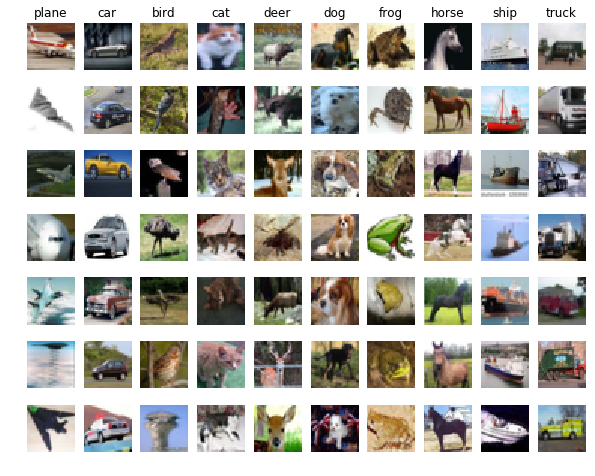

Training data shape:  (49000L, 3072L)
Validation data shape:  (1000L, 3072L)
Test data shape:  (10000L, 3072L)
Training data shape with bias term:  (49000L, 3073L)
Validation data shape with bias term:  (1000L, 3073L)
Test data shape with bias term:  (10000L, 3073L)


In [2]:
import utils

# Get the CIFAR-10 data broken up into train, validation and test sets

X_train, y_train, X_val, y_val, X_test, y_test = utils.get_CIFAR10_data()

## Implementing the loss function for softmax regression (naive version) 
Softmax regression generalizes logistic regression to classification problems where the class label $y$ can take on more than two possible values. This is useful for such problems as music genre classification and object recognition, where the goal is to distinguish between more than two different music genres or more than two different object categories.  Softmax regression is a supervised learning algorithm, but we will later be using it in conjunction with deep learning and unsupervised feature learning methods.
Recall that we are  given a data set 
$${\cal D} = \{(x^{(i)},y^{(i)}) | 1 \leq i \leq m; x^{(i)} \in \Re^{d+1}; {x_0}^{(i)} = 1, y^{(i)} \in \{1,\ldots, K\}\}, K>2 $$
Our probabilistic model $h_\theta(x)$ is defined as
\begin{eqnarray*}
 h_\theta(x) & = & 
 \left [ \begin{array}{l}
 P(y = 1|x; \theta) \\
 P(y = 2| x; \theta) \\
 \ldots \\
 P(y=K|x;\theta)
 \end{array} \right ]
 \end{eqnarray*}
 where 
 $$ P(y=k|x; \theta) = \frac{exp({\theta^{(k)}}^T x)} {\sum_{j=1}^{K} exp({\theta^{(j)}}^T x)} $$

The parameter  $\theta$ is a $(d+1)\times K$ matrix, where each column represents the parameter vector for class $k = 1,\ldots,K$.
$$\theta = \left [ \begin{array}{llll}
| & | & \ldots & | \\
| & | & \ldots & | \\
\theta^{(1)} & \theta^{(2)} & \ldots & \theta^{(K)} \\
|&  | & \ldots & | \\
| & | & \ldots  &| \\
\end{array}
\right ] $$

Numerical stability issues can come up in the computation of $P(y=k|x;\theta)$. Consider K=3, and $\theta^T x = [123, 456, 789]$. To compute $P(y=k|x;\theta)$ from these scores, we need to calculate $exp(123)$, $exp(456)$ and $exp(789)$, and sum them. These are very large numbers. However, we can get the same probabilities by subtracting the maximum ($789$) from  every element in $\theta^Tx$. Then we have the vector
$[-666,-333,0]$, and we can calculate $exp(-666)$, $exp(-333)$ and $exp(0)$, sum them (call the sum $S$) and then calculate $exp(-666)/S$, $exp(-333/S)$ and $exp(0)/S$.
 
The cost function $J(\theta)$ for softmax regression is derived from the negative log likelihood of the data ${\cal D}$, assuming that  $P(y|x;\theta) = h_\theta(x)$ as defined above.

$$J(\theta) = -\frac{1}{m}\sum_{i=1}^{m} \sum_{k=1}^{K} I\{y^{(i)} = k\} log \frac{exp({\theta^{(k)}}^T x^{(i)})}{\sum_{j=1}^{K} exp({\theta^{(j)}}^T x^{(i)})}  + \frac{\lambda}{2m} \sum_{j=0}^{d}\sum_{k=1}^{K} {{\theta_j}^{(k)}}^2 $$

where $I\{c\}$ is the indicator function which evaluates to 1 when $c$ is a true statement and to $0$ otherwise. The second term is a regularization term, where $\lambda$ is the regularization strength. While it is customary to exclude the bias term in L2 regularization, we include it here because it does not make a huge difference in the final result. You can check this for yourself on the CIFAR-10 dataset. You should implement this loss function using **for** loops for the summations in the function **softmax\_loss\_naive** in **softmax.py**. Once you have the loss function implemented, the cell below will run your loss function for a randomly initialized $\theta$ matrix with 49000 training images and labels with $\lambda$ set to 0. You should expect to see a value of about $-log_e(0.1)$ (Why?).

In [3]:
from softmax import softmax_loss_naive, softmax_loss_vectorized

# First implement the naive softmax loss function with nested loops.
# Open the file softmax.py and implement the
# softmax_loss_naive function.

# Generate a random softmax theta matrix and use it to compute the loss.

theta = np.random.randn(3073,10) * 0.0001
loss, grad = softmax_loss_naive(theta, X_train, y_train, 0.0)

# Loss should be something close to 2.38

print 'loss: (should be close to 2.38): ', loss

loss: (should be close to 2.38):  2.35336823991


## Implementing the gradient of loss function for softmax regression (naive version) 
The derivative of the loss function $J(\theta)$ with respect to the $\theta^{(k)}$ is

$$ \nabla_{\theta^{(k)}} J(\theta) = - \frac{1}{m} \sum_{i=1}^{m} [x^{(i)} (1\{y^{(i)}=k\} - P(y^{(i)}=k|x^{(i)};\theta))] +\frac{\lambda}{m} \theta^{(k)}$$

Implement the analytical derivative computation in **softmax\_loss\_naive** in **softmax.py**.

We  check your implementation of the gradient using the method of finite differences. The functions in ** gradient\_check.py** compute the numerical gradient of a function $f$ as follows:
$$ \frac{\partial f(x)}{\partial x} = \frac{f(x+h)-f(x-h)}{2h} $$
for a very small $h$. The cell below will check your gradient against the numerically approximated gradient -- you should expect to see differences between the two gradients of the order of $10^{-7}$ or less. 


In [4]:
import time
# Open the file softmax.py and implement the gradient in the
# softmax_loss_naive function.

# Use numeric gradient checking as a debugging tool.
# The numeric gradient should be close to the analytic gradient. (within 1e-7)

from gradient_check import grad_check_sparse
f = lambda th: softmax_loss_naive(th, X_train, y_train, 0.0)[0]
grad_numerical = grad_check_sparse(f, theta, grad, 10)

tic = time.time()
loss_naive, grad_naive = softmax_loss_naive(theta, X_train, y_train, 0.00001)
toc = time.time()
print 'naive loss: %e computed in %fs' % (loss_naive, toc - tic)

numerical: -0.105560 analytic: -0.105560, relative error: 7.271705e-07
numerical: -0.753916 analytic: -0.753916, relative error: 3.989858e-08
numerical: 0.502602 analytic: 0.502603, relative error: 6.785466e-08
numerical: -1.483322 analytic: -1.483322, relative error: 3.251961e-08
numerical: 0.826342 analytic: 0.826341, relative error: 6.426004e-08
numerical: 0.100206 analytic: 0.100206, relative error: 3.858497e-07
numerical: -0.143181 analytic: -0.143181, relative error: 3.234657e-07
numerical: 1.274754 analytic: 1.274754, relative error: 4.766166e-08
numerical: 0.142215 analytic: 0.142215, relative error: 3.724646e-07
numerical: 0.769793 analytic: 0.769793, relative error: 5.101976e-08
naive loss: 2.353368e+00 computed in 96.960000s


## Implementing the loss function and its gradient for softmax regression (vectorized version) 
Now complete the function **softmax\_loss\_vectorized** in **softmax.py** to implement the loss function $J(\theta)$ without using any **for** loops. Re-express the computation in terms of matrix operations on $X$, $y$ and $\theta$. 
Now vectorize the gradient computation in **softmax\_loss\_vectorized** in **softmax.py**. Once you complete this, the cell below will run and time your naive and vectorized implementations -- you should expect to see at least one order of magnitude difference in run time between the two implementations. 

In [5]:
# Now that we have a naive implementation of the softmax loss function and its gradient,
# implement a vectorized version in softmax_loss_vectorized.
# The two versions should compute the same results, but the vectorized version should be
# much faster.
from softmax import softmax_loss_vectorized
tic = time.time()
loss_vectorized, grad_vectorized = softmax_loss_vectorized(theta, X_train, y_train, 0.00001)
toc = time.time()
print 'vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic)

# We use the Frobenius norm to compare the two versions
# of the gradient.

grad_difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print 'Loss difference: %f' % np.abs(loss_naive - loss_vectorized)
print 'Gradient difference: %f' % grad_difference

vectorized loss: 2.353368e+00 computed in 0.769000s
Loss difference: 0.000000
Gradient difference: 0.000000


## Implementing mini-batch gradient descent 
In large-scale applications, the training data can have millions of examples. Hence, it seems wasteful to compute the  loss function over the entire training set in order to perform only a single parameter update. A very common approach to addressing this challenge is to compute the gradient over batches of the training data. For example, a typical batch contains 256 examples from a training set of over 1.2 million. This batch is then used to perform a parameter update:
$$ \theta^{(k)} \to \theta^{(k)} - \alpha \nabla_{\theta^{(k)}} J(\theta) $$
where $\alpha$ is the step size or learning rate for gradient descent.

Implement mini-batch gradient descent in the method **train** in **linear_classifier.py** using the description provided in the documentation of the method. You can set the **verbose** argument of **train** to be **True** and observe how the loss function varies with iteration number.

You will test your implementation of mini-batch gradient descent in the search for hyperparameters below.

## Using a validation set to select regularization lambda and learning rate for   gradient descent
There are many hyper parameters to be selected for mini batch gradient descent -- the batch size, the number of iterations, and the learning rate. For the loss function, we also need to select $\lambda$, the regularization strength. In this exercise, we have pre-selected a batch size of 400 and an iteration count of 4000. Now, use the validation set provided to sweep the learning rate and the $\lambda$ parameter space, using the suggested values in the cell below to find the best combination of these two hyper parameters. Fill in the code to do this in the section marked **TODO** below.

Once you find the best values of $\lambda$ and learning rate, insert code in the cell below to train a softmax classifier on the training data with the best hyper parameters and save this classifier in the variable  **best\_softmax**.  

In [13]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of over 0.35 on the validation set and the test set.

import linear_classifier

results = {}
best_val = -1
best_softmax = None
learning_rates = [1e-7, 5e-7, 1e-6, 5e-6]
regularization_strengths = [5e4, 1e5, 5e5, 1e8]

################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# Save the best trained softmax classifer in variable best_softmax.            #
################################################################################

linear_classifier_model = linear_classifier.Softmax()

for lr in learning_rates:
    for reg in regularization_strengths:
        linear_classifier_model.train(X_train, y_train, lr, reg, 4000, 400)
        train_accuracy = 1.0 *np.sum(linear_classifier_model.predict(X_train) == y_train) / y_train.size
        val_accuracy =  1.0 *np.sum(linear_classifier_model.predict(X_val) == y_val) / y_val.size
        results[(lr, reg)] = (train_accuracy, val_accuracy)
        if best_val < val_accuracy:
            best_val = val_accuracy
            best_softmax = linear_classifier.Softmax()
            best_softmax.train(X_train, y_train, lr, reg, 4000, 400)



################################################################################
#                              END OF YOUR CODE                                #
################################################################################
    
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print 'lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy)
    
print 'best validation accuracy achieved during cross-validation: %f' % best_val

lr 1.000000e-07 reg 5.000000e+04 train accuracy: 0.290000 val accuracy: 0.298000
lr 1.000000e-07 reg 1.000000e+05 train accuracy: 0.326531 val accuracy: 0.329000
lr 1.000000e-07 reg 5.000000e+05 train accuracy: 0.370082 val accuracy: 0.368000
lr 1.000000e-07 reg 1.000000e+08 train accuracy: 0.279429 val accuracy: 0.290000
lr 5.000000e-07 reg 5.000000e+04 train accuracy: 0.425347 val accuracy: 0.413000
lr 5.000000e-07 reg 1.000000e+05 train accuracy: 0.434796 val accuracy: 0.411000
lr 5.000000e-07 reg 5.000000e+05 train accuracy: 0.414102 val accuracy: 0.403000
lr 5.000000e-07 reg 1.000000e+08 train accuracy: 0.272184 val accuracy: 0.278000
lr 1.000000e-06 reg 5.000000e+04 train accuracy: 0.434347 val accuracy: 0.419000
lr 1.000000e-06 reg 1.000000e+05 train accuracy: 0.437735 val accuracy: 0.424000
lr 1.000000e-06 reg 5.000000e+05 train accuracy: 0.410510 val accuracy: 0.403000
lr 1.000000e-06 reg 1.000000e+08 train accuracy: 0.287776 val accuracy: 0.296000
lr 5.000000e-06 reg 5.000000

## Evaluating the best softmax classifier on the test set and visualizing the coefficients
The best\_softmax classifier will be  evaluated on the set aside test set and you should expect to see an overall accuracy of over 35%. 

Compute the confusion matrix (you can use the confusion\_matrix function in **sklearn.metrics** on the test set for your predictor and interpret the visualized coefficients in the light of the errors made by the classifier.

We can remove the bias term from the $\theta$ matrix and reshape each column of the matrix which is a parameter vector of size $3072$ back into an array of size $32\times 32 \times 3$ and visualize the results as an image. The cell below  constructs such a plot, similar to the one in Figure 2 in hw3.pdf. 

softmax on raw pixels final test set accuracy: 0.398700
[[556  37  34  23  22  24  28  34 167  75]
 [ 83 486  16  41  17  31  44  34  86 162]
 [128  47 215  93 121  87 161  67  51  30]
 [ 70  69  73 245  58 187 141  42  44  71]
 [ 80  28 130  67 284  89 169  91  27  35]
 [ 60  51  85 146  73 331 102  66  60  26]
 [ 26  49  63  94  81  79 519  33  24  32]
 [ 80  44  56  55  83  87  61 407  46  81]
 [222  80  10  24   6  41  12  15 499  91]
 [ 88 202  12  27  16  17  47  48  98 445]]


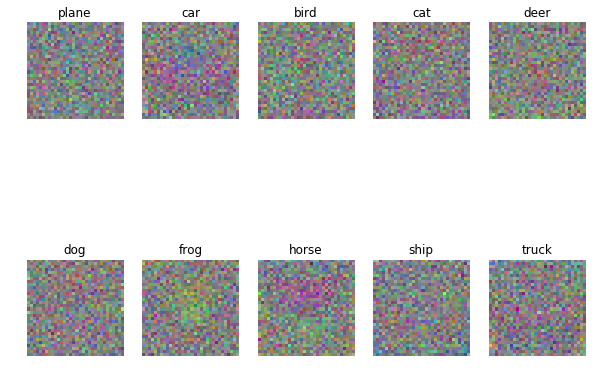

In [14]:
# Evaluate the best softmax classifier on test set

y_test_pred = best_softmax.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print 'softmax on raw pixels final test set accuracy: %f' % (test_accuracy, )

# compute confusion matrix
from sklearn.metrics import confusion_matrix
print confusion_matrix(y_test,y_test_pred)

# Visualize the learned weights for each class`

theta = best_softmax.theta[1:,:].T # strip out the bias term
theta = theta.reshape(10, 32, 32, 3)

theta_min, theta_max = np.min(theta), np.max(theta)

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in xrange(10):
  plt.subplot(2, 5, i + 1)
  
  # Rescale the weights to be between 0 and 255
  thetaimg = 255.0 * (theta[i].squeeze() - theta_min) / (theta_max - theta_min)
  plt.imshow(thetaimg.astype('uint8'))
  plt.axis('off')
  plt.title(classes[i])

plt.show()

## Extra credit:  Experimenting with other hyper parameters and optimization method
We chose a batch size of 400 and 4000 iterations for our previous experiments. Explore larger and smaller batch sizes, choosing an appropriate number of iterations (by specifying a tolerance on differences in values of the loss function or its gradient in successive iterations) with the validation set. Produce plots that show the variation of test set accuracy as a function of batch size/number of iterations. You will have to determine the right settings for regularization strength $\lambda$ and learning rate for each batch size/number of iterations combination. What is the best batch size/number of iterations/learning rate/regularization strength combination for this problem? What is the best test set accuracy that can be achieved by this combination? 

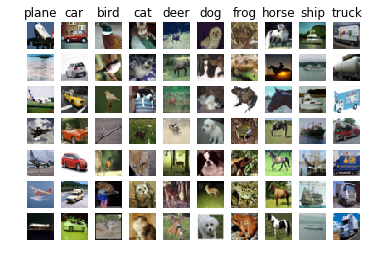

Training data shape:  (49000L, 3072L)
Validation data shape:  (1000L, 3072L)
Test data shape:  (10000L, 3072L)
Training data shape with bias term:  (49000L, 3073L)
Validation data shape with bias term:  (1000L, 3073L)
Test data shape with bias term:  (10000L, 3073L)


In [8]:
import random
import numpy as np
import matplotlib.pyplot as plt
import utils

# Get the CIFAR-10 data broken up into train, validation and test sets

X_train, y_train, X_val, y_val, X_test, y_test = utils.get_CIFAR10_data()

from softmax import softmax_loss_naive, softmax_loss_vectorized

# First implement the naive softmax loss function with nested loops.
# Open the file softmax.py and implement the
# softmax_loss_naive function.

# Generate a random softmax theta matrix and use it to compute the loss.

theta = np.random.randn(3073,10) * 0.0001
loss, grad = softmax_loss_naive(theta, X_train, y_train, 0.0)

import linear_classifier


best_lr = 1e-06
best_reg = 1e5
best_batch_size = -1
best_iteration = -1
best_val = -1
best_softmax = None
batch_sizes = [200, 300, 400, 500]
iterations = [2000, 3000, 4000, 5000]

records = np.zeros((len(batch_sizes), len(iterations)))
for bs_idx in xrange(len(batch_sizes)):
    for it_idx in xrange(len(iterations)):
        softmax_model = linear_classifier.Softmax()
        softmax_model.train(X_train, y_train, best_lr, best_reg, iterations[it_idx], batch_sizes[bs_idx])
        accuracy = np.mean(softmax_model.predict(X_val) == y_val)
        records[bs_idx, it_idx] = accuracy
        if (best_val < accuracy) :
            best_val = accuracy
            best_softmax = softmax_model
            best_reg = regularization_strengths[reg_idx]
            best_batch_size = batch_sizes[bs_idx]
            best_iteration = iterations[it_idx]

In [24]:
# Print out results.
for bs_idx in xrange(len(batch_sizes)):
    for it_idx in xrange(len(iterations)):
        print 'batch size %e iteration %e  val accuracy: %f' % (
                batch_sizes[bs_idx], iterations[it_idx], records[bs_idx, it_idx])
    
print 'best validation accuracy achieved during cross-validation: %f' % best_val

batch size 2.000000e+02 iteration 2.000000e+03  val accuracy: 0.393000
batch size 2.000000e+02 iteration 3.000000e+03  val accuracy: 0.400000
batch size 2.000000e+02 iteration 4.000000e+03  val accuracy: 0.398000
batch size 2.000000e+02 iteration 5.000000e+03  val accuracy: 0.409000
batch size 3.000000e+02 iteration 2.000000e+03  val accuracy: 0.394000
batch size 3.000000e+02 iteration 3.000000e+03  val accuracy: 0.397000
batch size 3.000000e+02 iteration 4.000000e+03  val accuracy: 0.417000
batch size 3.000000e+02 iteration 5.000000e+03  val accuracy: 0.412000
batch size 4.000000e+02 iteration 2.000000e+03  val accuracy: 0.368000
batch size 4.000000e+02 iteration 3.000000e+03  val accuracy: 0.398000
batch size 4.000000e+02 iteration 4.000000e+03  val accuracy: 0.400000
batch size 4.000000e+02 iteration 5.000000e+03  val accuracy: 0.422000
batch size 5.000000e+02 iteration 2.000000e+03  val accuracy: 0.391000
batch size 5.000000e+02 iteration 3.000000e+03  val accuracy: 0.393000
batch 

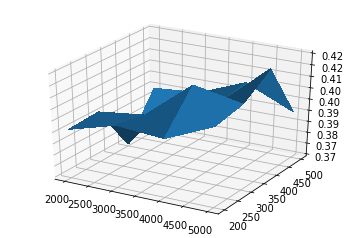

In [19]:
## Produce plots that show the variation of test set accuracy as a
## function of batch size/number of iterations.
from mpl_toolkits.mplot3d import axes3d, Axes3D #<-- Note the capitalization! 
from matplotlib.ticker import LinearLocator, FormatStrFormatter
figure = plt.figure()

ax = Axes3D(fig)

X, Y = np.meshgrid(iterations, batch_sizes)
ax = figure.gca(projection='3d')
surf = ax.plot_surface(X, Y, records, rstride=1, cstride=1, 
                       linewidth=0, antialiased=False)

ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
plt.show()

In [30]:
## What is the best batch size/number of iterations/learning rate/regularization
##  strength combination for this problem?
best_test = -1
best_softmax = None
best_lr = -1
best_reg = -1
best_batch_size = -1
best_iteration = -1
learning_rates = [1e-7, 5e-7, 1e-6, 5e-6]
regularization_strengths = [5e4, 1e5, 5e5, 1e8]
batch_sizes = [200, 300, 400, 500]
iterations = [2000, 3000, 4000, 5000]

records = np.zeros((len(learning_rates), len(regularization_strengths),len(batch_sizes), len(iterations)))
for lr_idx in xrange(len(learning_rates)):
    for reg_idx in xrange(len(regularization_strengths)):
        for bs_idx in xrange(len(batch_sizes)):
            for it_idx in xrange(len(iterations)):
                softmax_model = linear_classifier.Softmax()
                softmax_model.train(X_train, y_train, learning_rates[lr_idx], regularization_strengths[reg_idx], iterations[it_idx], batch_sizes[bs_idx], verbose = True)
                accuracy = np.mean(softmax_model.predict(X_val) == y_val)
                print 'lr %e reg %e batch size %e iteration %e  val accuracy: %f' % (
                        learning_rates[lr_idx], regularization_strengths[reg_idx], batch_sizes[bs_idx], iterations[it_idx], accuracy)
                records[lr_idx, reg_idx, bs_idx, it_idx] = accuracy
                if (best_test < accuracy) :
                    best_test = accuracy
                    best_softmax = softmax_model
                    best_lr = learning_rates[lr_idx]
                    best_reg = regularization_strengths[reg_idx]
                    best_batch_size = batch_sizes[bs_idx]
                    best_iteration = iterations[it_idx]

iteration 0 / 2000: loss 8.557064
iteration 100 / 2000: loss 7.074112
iteration 200 / 2000: loss 7.633739
iteration 300 / 2000: loss 7.049505
iteration 400 / 2000: loss 7.025447
iteration 500 / 2000: loss 6.481599
iteration 600 / 2000: loss 6.418312
iteration 700 / 2000: loss 6.272577
iteration 800 / 2000: loss 6.341835
iteration 900 / 2000: loss 6.530444
iteration 1000 / 2000: loss 6.399985
iteration 1100 / 2000: loss 6.240866
iteration 1200 / 2000: loss 6.130780
iteration 1300 / 2000: loss 6.104540
iteration 1400 / 2000: loss 6.024836
iteration 1500 / 2000: loss 5.879691
iteration 1600 / 2000: loss 5.922236
iteration 1700 / 2000: loss 5.796924
iteration 1800 / 2000: loss 5.973017
iteration 1900 / 2000: loss 5.951753
lr 1.000000e-07 reg 5.000000e+04 batch size 2.000000e+02 iteration 2.000000e+03  val accuracy: 0.261000
iteration 0 / 3000: loss 8.980963
iteration 100 / 3000: loss 7.692950
iteration 200 / 3000: loss 7.233264
iteration 300 / 3000: loss 7.174971
iteration 400 / 3000: loss

iteration 1700 / 4000: loss 4.875106
iteration 1800 / 4000: loss 4.960011
iteration 1900 / 4000: loss 4.670805
iteration 2000 / 4000: loss 4.912218
iteration 2100 / 4000: loss 4.879417
iteration 2200 / 4000: loss 4.524142
iteration 2300 / 4000: loss 4.745689
iteration 2400 / 4000: loss 4.623291
iteration 2500 / 4000: loss 4.698371
iteration 2600 / 4000: loss 4.674614
iteration 2700 / 4000: loss 4.567169
iteration 2800 / 4000: loss 4.435619
iteration 2900 / 4000: loss 4.519289
iteration 3000 / 4000: loss 4.404908
iteration 3100 / 4000: loss 4.571106
iteration 3200 / 4000: loss 4.646740
iteration 3300 / 4000: loss 4.410520
iteration 3400 / 4000: loss 4.488652
iteration 3500 / 4000: loss 4.467242
iteration 3600 / 4000: loss 4.361455
iteration 3700 / 4000: loss 4.251215
iteration 3800 / 4000: loss 4.369721
iteration 3900 / 4000: loss 4.457248
lr 1.000000e-07 reg 5.000000e+04 batch size 3.000000e+02 iteration 4.000000e+03  val accuracy: 0.305000
iteration 0 / 5000: loss 8.345824
iteration 1

iteration 4600 / 5000: loss 3.888038
iteration 4700 / 5000: loss 3.826302
iteration 4800 / 5000: loss 3.800331
iteration 4900 / 5000: loss 3.855525
lr 1.000000e-07 reg 5.000000e+04 batch size 4.000000e+02 iteration 5.000000e+03  val accuracy: 0.299000
iteration 0 / 2000: loss 7.586549
iteration 100 / 2000: loss 5.560976
iteration 200 / 2000: loss 5.169535
iteration 300 / 2000: loss 4.837953
iteration 400 / 2000: loss 4.852331
iteration 500 / 2000: loss 4.544314
iteration 600 / 2000: loss 4.574463
iteration 700 / 2000: loss 4.398542
iteration 800 / 2000: loss 4.328615
iteration 900 / 2000: loss 4.207510
iteration 1000 / 2000: loss 4.206543
iteration 1100 / 2000: loss 4.209293
iteration 1200 / 2000: loss 4.112824
iteration 1300 / 2000: loss 4.105650
iteration 1400 / 2000: loss 4.083056
iteration 1500 / 2000: loss 4.042461
iteration 1600 / 2000: loss 3.976578
iteration 1700 / 2000: loss 3.989129
iteration 1800 / 2000: loss 3.996424
iteration 1900 / 2000: loss 4.011680
lr 1.000000e-07 reg 

iteration 1000 / 4000: loss 9.782312
iteration 1100 / 4000: loss 9.563940
iteration 1200 / 4000: loss 9.468978
iteration 1300 / 4000: loss 9.374699
iteration 1400 / 4000: loss 9.084209
iteration 1500 / 4000: loss 9.160876
iteration 1600 / 4000: loss 8.859408
iteration 1700 / 4000: loss 8.796132
iteration 1800 / 4000: loss 9.018311
iteration 1900 / 4000: loss 8.639698
iteration 2000 / 4000: loss 8.602681
iteration 2100 / 4000: loss 8.564416
iteration 2200 / 4000: loss 8.563591
iteration 2300 / 4000: loss 8.303672
iteration 2400 / 4000: loss 8.190116
iteration 2500 / 4000: loss 8.176985
iteration 2600 / 4000: loss 8.144653
iteration 2700 / 4000: loss 8.054861
iteration 2800 / 4000: loss 7.909500
iteration 2900 / 4000: loss 7.727702
iteration 3000 / 4000: loss 7.895709
iteration 3100 / 4000: loss 7.595719
iteration 3200 / 4000: loss 7.764212
iteration 3300 / 4000: loss 7.591338
iteration 3400 / 4000: loss 7.408663
iteration 3500 / 4000: loss 7.599491
iteration 3600 / 4000: loss 7.268546
i

iteration 3900 / 5000: loss 6.012318
iteration 4000 / 5000: loss 5.843499
iteration 4100 / 5000: loss 6.030175
iteration 4200 / 5000: loss 5.799753
iteration 4300 / 5000: loss 5.708753
iteration 4400 / 5000: loss 5.935742
iteration 4500 / 5000: loss 5.779820
iteration 4600 / 5000: loss 5.677982
iteration 4700 / 5000: loss 5.719579
iteration 4800 / 5000: loss 5.671777
iteration 4900 / 5000: loss 5.441262
lr 1.000000e-07 reg 1.000000e+05 batch size 3.000000e+02 iteration 5.000000e+03  val accuracy: 0.315000
iteration 0 / 2000: loss 8.933218
iteration 100 / 2000: loss 7.713939
iteration 200 / 2000: loss 7.346541
iteration 300 / 2000: loss 7.021015
iteration 400 / 2000: loss 6.931326
iteration 500 / 2000: loss 6.797999
iteration 600 / 2000: loss 6.598717
iteration 700 / 2000: loss 6.527766
iteration 800 / 2000: loss 6.380398
iteration 900 / 2000: loss 6.324933
iteration 1000 / 2000: loss 6.264458
iteration 1100 / 2000: loss 6.322405
iteration 1200 / 2000: loss 6.200466
iteration 1300 / 200

iteration 300 / 4000: loss 6.201524
iteration 400 / 4000: loss 6.066450
iteration 500 / 4000: loss 5.971068
iteration 600 / 4000: loss 5.903062
iteration 700 / 4000: loss 5.704274
iteration 800 / 4000: loss 5.766534
iteration 900 / 4000: loss 5.642085
iteration 1000 / 4000: loss 5.613725
iteration 1100 / 4000: loss 5.336065
iteration 1200 / 4000: loss 5.373567
iteration 1300 / 4000: loss 5.328025
iteration 1400 / 4000: loss 5.250092
iteration 1500 / 4000: loss 5.378555
iteration 1600 / 4000: loss 5.171342
iteration 1700 / 4000: loss 5.261374
iteration 1800 / 4000: loss 5.257024
iteration 1900 / 4000: loss 5.021294
iteration 2000 / 4000: loss 5.188299
iteration 2100 / 4000: loss 5.092328
iteration 2200 / 4000: loss 5.025152
iteration 2300 / 4000: loss 5.018206
iteration 2400 / 4000: loss 5.023578
iteration 2500 / 4000: loss 5.114434
iteration 2600 / 4000: loss 5.082145
iteration 2700 / 4000: loss 5.016322
iteration 2800 / 4000: loss 5.005687
iteration 2900 / 4000: loss 4.929259
iteratio

iteration 3000 / 5000: loss 10.298260
iteration 3100 / 5000: loss 9.910565
iteration 3200 / 5000: loss 9.407092
iteration 3300 / 5000: loss 9.081592
iteration 3400 / 5000: loss 8.628307
iteration 3500 / 5000: loss 8.415682
iteration 3600 / 5000: loss 8.074210
iteration 3700 / 5000: loss 7.730995
iteration 3800 / 5000: loss 7.503367
iteration 3900 / 5000: loss 7.341607
iteration 4000 / 5000: loss 6.858763
iteration 4100 / 5000: loss 6.600542
iteration 4200 / 5000: loss 6.417750
iteration 4300 / 5000: loss 6.260947
iteration 4400 / 5000: loss 6.065542
iteration 4500 / 5000: loss 5.712866
iteration 4600 / 5000: loss 5.425579
iteration 4700 / 5000: loss 5.358001
iteration 4800 / 5000: loss 5.253143
iteration 4900 / 5000: loss 5.219229
lr 1.000000e-07 reg 5.000000e+05 batch size 2.000000e+02 iteration 5.000000e+03  val accuracy: 0.361000
iteration 0 / 2000: loss 31.417388
iteration 100 / 2000: loss 28.554533
iteration 200 / 2000: loss 27.404499
iteration 300 / 2000: loss 26.005236
iteration

iteration 2300 / 3000: loss 12.894351
iteration 2400 / 3000: loss 12.383928
iteration 2500 / 3000: loss 12.133140
iteration 2600 / 3000: loss 11.854940
iteration 2700 / 3000: loss 11.583683
iteration 2800 / 3000: loss 11.296032
iteration 2900 / 3000: loss 11.010799
lr 1.000000e-07 reg 5.000000e+05 batch size 4.000000e+02 iteration 3.000000e+03  val accuracy: 0.303000
iteration 0 / 4000: loss 25.492070
iteration 100 / 4000: loss 22.535560
iteration 200 / 4000: loss 21.783833
iteration 300 / 4000: loss 21.032612
iteration 400 / 4000: loss 20.298887
iteration 500 / 4000: loss 19.790805
iteration 600 / 4000: loss 19.273462
iteration 700 / 4000: loss 18.637249
iteration 800 / 4000: loss 18.241810
iteration 900 / 4000: loss 17.631514
iteration 1000 / 4000: loss 17.181675
iteration 1100 / 4000: loss 16.929022
iteration 1200 / 4000: loss 16.502331
iteration 1300 / 4000: loss 15.978842
iteration 1400 / 4000: loss 15.714839
iteration 1500 / 4000: loss 15.336965
iteration 1600 / 4000: loss 14.908

iteration 1500 / 5000: loss 13.540869
iteration 1600 / 5000: loss 13.368223
iteration 1700 / 5000: loss 13.025717
iteration 1800 / 5000: loss 12.828073
iteration 1900 / 5000: loss 12.582812
iteration 2000 / 5000: loss 12.373199
iteration 2100 / 5000: loss 12.057971
iteration 2200 / 5000: loss 11.862969
iteration 2300 / 5000: loss 11.668140
iteration 2400 / 5000: loss 11.471984
iteration 2500 / 5000: loss 11.258931
iteration 2600 / 5000: loss 11.040832
iteration 2700 / 5000: loss 10.755196
iteration 2800 / 5000: loss 10.552894
iteration 2900 / 5000: loss 10.469947
iteration 3000 / 5000: loss 10.331159
iteration 3100 / 5000: loss 10.079334
iteration 3200 / 5000: loss 9.936137
iteration 3300 / 5000: loss 9.761636
iteration 3400 / 5000: loss 9.595698
iteration 3500 / 5000: loss 9.368261
iteration 3600 / 5000: loss 9.290797
iteration 3700 / 5000: loss 9.129037
iteration 3800 / 5000: loss 8.918872
iteration 3900 / 5000: loss 8.760116
iteration 4000 / 5000: loss 8.638186
iteration 4100 / 5000

iteration 1100 / 3000: loss 2.217652
iteration 1200 / 3000: loss 2.209363
iteration 1300 / 3000: loss 2.230359
iteration 1400 / 3000: loss 2.238374
iteration 1500 / 3000: loss 2.248113
iteration 1600 / 3000: loss 2.236879
iteration 1700 / 3000: loss 2.234887
iteration 1800 / 3000: loss 2.225509
iteration 1900 / 3000: loss 2.201767
iteration 2000 / 3000: loss 2.238088
iteration 2100 / 3000: loss 2.214438
iteration 2200 / 3000: loss 2.213246
iteration 2300 / 3000: loss 2.221655
iteration 2400 / 3000: loss 2.204706
iteration 2500 / 3000: loss 2.227602
iteration 2600 / 3000: loss 2.230551
iteration 2700 / 3000: loss 2.222543
iteration 2800 / 3000: loss 2.248343
iteration 2900 / 3000: loss 2.219132
lr 1.000000e-07 reg 1.000000e+08 batch size 3.000000e+02 iteration 3.000000e+03  val accuracy: 0.285000
iteration 0 / 4000: loss 5089.566495
iteration 100 / 4000: loss 7.980220
iteration 200 / 4000: loss 2.219580
iteration 300 / 4000: loss 2.228143
iteration 400 / 4000: loss 2.230934
iteration 50

iteration 700 / 5000: loss 2.198692
iteration 800 / 5000: loss 2.201284
iteration 900 / 5000: loss 2.197900
iteration 1000 / 5000: loss 2.211855
iteration 1100 / 5000: loss 2.211034
iteration 1200 / 5000: loss 2.203075
iteration 1300 / 5000: loss 2.195612
iteration 1400 / 5000: loss 2.203001
iteration 1500 / 5000: loss 2.214139
iteration 1600 / 5000: loss 2.213443
iteration 1700 / 5000: loss 2.230577
iteration 1800 / 5000: loss 2.209281
iteration 1900 / 5000: loss 2.204366
iteration 2000 / 5000: loss 2.225665
iteration 2100 / 5000: loss 2.205757
iteration 2200 / 5000: loss 2.211009
iteration 2300 / 5000: loss 2.194763
iteration 2400 / 5000: loss 2.201189
iteration 2500 / 5000: loss 2.219060
iteration 2600 / 5000: loss 2.222644
iteration 2700 / 5000: loss 2.194465
iteration 2800 / 5000: loss 2.217433
iteration 2900 / 5000: loss 2.222422
iteration 3000 / 5000: loss 2.218077
iteration 3100 / 5000: loss 2.203227
iteration 3200 / 5000: loss 2.216760
iteration 3300 / 5000: loss 2.191993
iter

iteration 300 / 3000: loss 6.062638
iteration 400 / 3000: loss 5.662054
iteration 500 / 3000: loss 5.623413
iteration 600 / 3000: loss 5.442170
iteration 700 / 3000: loss 5.351151
iteration 800 / 3000: loss 5.249109
iteration 900 / 3000: loss 5.064983
iteration 1000 / 3000: loss 4.809344
iteration 1100 / 3000: loss 4.883677
iteration 1200 / 3000: loss 4.735097
iteration 1300 / 3000: loss 4.691299
iteration 1400 / 3000: loss 4.509130
iteration 1500 / 3000: loss 4.365681
iteration 1600 / 3000: loss 4.377875
iteration 1700 / 3000: loss 4.336475
iteration 1800 / 3000: loss 4.278336
iteration 1900 / 3000: loss 4.138953
iteration 2000 / 3000: loss 3.985258
iteration 2100 / 3000: loss 4.062693
iteration 2200 / 3000: loss 3.776240
iteration 2300 / 3000: loss 3.977500
iteration 2400 / 3000: loss 3.922505
iteration 2500 / 3000: loss 3.564098
iteration 2600 / 3000: loss 3.547407
iteration 2700 / 3000: loss 3.658550
iteration 2800 / 3000: loss 3.616282
iteration 2900 / 3000: loss 3.452980
lr 5.000

iteration 100 / 5000: loss 5.581296
iteration 200 / 5000: loss 5.386558
iteration 300 / 5000: loss 4.998556
iteration 400 / 5000: loss 4.733253
iteration 500 / 5000: loss 4.629633
iteration 600 / 5000: loss 4.659741
iteration 700 / 5000: loss 4.455719
iteration 800 / 5000: loss 4.520899
iteration 900 / 5000: loss 4.340257
iteration 1000 / 5000: loss 4.190163
iteration 1100 / 5000: loss 4.171952
iteration 1200 / 5000: loss 4.143279
iteration 1300 / 5000: loss 4.071246
iteration 1400 / 5000: loss 3.924166
iteration 1500 / 5000: loss 3.887619
iteration 1600 / 5000: loss 3.747137
iteration 1700 / 5000: loss 3.799683
iteration 1800 / 5000: loss 3.836239
iteration 1900 / 5000: loss 3.834905
iteration 2000 / 5000: loss 3.485197
iteration 2100 / 5000: loss 3.622902
iteration 2200 / 5000: loss 3.489406
iteration 2300 / 5000: loss 3.579905
iteration 2400 / 5000: loss 3.530928
iteration 2500 / 5000: loss 3.558639
iteration 2600 / 5000: loss 3.373546
iteration 2700 / 5000: loss 3.356052
iteration 

iteration 100 / 3000: loss 4.408571
iteration 200 / 3000: loss 4.132974
iteration 300 / 3000: loss 3.983444
iteration 400 / 3000: loss 3.927181
iteration 500 / 3000: loss 3.714352
iteration 600 / 3000: loss 3.707588
iteration 700 / 3000: loss 3.617046
iteration 800 / 3000: loss 3.525987
iteration 900 / 3000: loss 3.510438
iteration 1000 / 3000: loss 3.553589
iteration 1100 / 3000: loss 3.443072
iteration 1200 / 3000: loss 3.342033
iteration 1300 / 3000: loss 3.307444
iteration 1400 / 3000: loss 3.383373
iteration 1500 / 3000: loss 3.264663
iteration 1600 / 3000: loss 3.295883
iteration 1700 / 3000: loss 3.275631
iteration 1800 / 3000: loss 3.032064
iteration 1900 / 3000: loss 3.215933
iteration 2000 / 3000: loss 3.073396
iteration 2100 / 3000: loss 3.048741
iteration 2200 / 3000: loss 3.203533
iteration 2300 / 3000: loss 3.076488
iteration 2400 / 3000: loss 3.089322
iteration 2500 / 3000: loss 2.909077
iteration 2600 / 3000: loss 3.055072
iteration 2700 / 3000: loss 2.953418
iteration 

iteration 100 / 5000: loss 10.226734
iteration 200 / 5000: loss 9.628938
iteration 300 / 5000: loss 9.066862
iteration 400 / 5000: loss 8.396136
iteration 500 / 5000: loss 8.103423
iteration 600 / 5000: loss 7.514400
iteration 700 / 5000: loss 7.320718
iteration 800 / 5000: loss 7.094712
iteration 900 / 5000: loss 6.866793
iteration 1000 / 5000: loss 6.460257
iteration 1100 / 5000: loss 6.264738
iteration 1200 / 5000: loss 6.055779
iteration 1300 / 5000: loss 5.715728
iteration 1400 / 5000: loss 5.485792
iteration 1500 / 5000: loss 5.365956
iteration 1600 / 5000: loss 5.132942
iteration 1700 / 5000: loss 4.836692
iteration 1800 / 5000: loss 4.712592
iteration 1900 / 5000: loss 4.733285
iteration 2000 / 5000: loss 4.507170
iteration 2100 / 5000: loss 4.430171
iteration 2200 / 5000: loss 4.217887
iteration 2300 / 5000: loss 3.996571
iteration 2400 / 5000: loss 3.989779
iteration 2500 / 5000: loss 3.836333
iteration 2600 / 5000: loss 4.031446
iteration 2700 / 5000: loss 3.556535
iteration

iteration 100 / 3000: loss 6.878411
iteration 200 / 3000: loss 6.268943
iteration 300 / 3000: loss 6.114030
iteration 400 / 3000: loss 5.941743
iteration 500 / 3000: loss 5.699494
iteration 600 / 3000: loss 5.463816
iteration 700 / 3000: loss 5.337045
iteration 800 / 3000: loss 5.161292
iteration 900 / 3000: loss 5.142899
iteration 1000 / 3000: loss 4.911031
iteration 1100 / 3000: loss 4.836928
iteration 1200 / 3000: loss 4.806673
iteration 1300 / 3000: loss 4.597625
iteration 1400 / 3000: loss 4.590719
iteration 1500 / 3000: loss 4.564691
iteration 1600 / 3000: loss 4.364438
iteration 1700 / 3000: loss 4.315753
iteration 1800 / 3000: loss 4.277501
iteration 1900 / 3000: loss 4.055057
iteration 2000 / 3000: loss 4.028149
iteration 2100 / 3000: loss 4.010005
iteration 2200 / 3000: loss 3.990671
iteration 2300 / 3000: loss 3.932363
iteration 2400 / 3000: loss 3.813134
iteration 2500 / 3000: loss 3.771602
iteration 2600 / 3000: loss 3.736369
iteration 2700 / 3000: loss 3.596541
iteration 

iteration 100 / 5000: loss 6.186572
iteration 200 / 5000: loss 5.567964
iteration 300 / 5000: loss 5.406033
iteration 400 / 5000: loss 5.310386
iteration 500 / 5000: loss 5.021275
iteration 600 / 5000: loss 4.960722
iteration 700 / 5000: loss 4.850928
iteration 800 / 5000: loss 4.748813
iteration 900 / 5000: loss 4.676488
iteration 1000 / 5000: loss 4.651337
iteration 1100 / 5000: loss 4.448967
iteration 1200 / 5000: loss 4.265256
iteration 1300 / 5000: loss 4.334742
iteration 1400 / 5000: loss 4.229138
iteration 1500 / 5000: loss 4.109694
iteration 1600 / 5000: loss 4.080625
iteration 1700 / 5000: loss 4.006964
iteration 1800 / 5000: loss 4.124266
iteration 1900 / 5000: loss 3.941150
iteration 2000 / 5000: loss 3.828347
iteration 2100 / 5000: loss 3.857088
iteration 2200 / 5000: loss 3.781458
iteration 2300 / 5000: loss 3.714609
iteration 2400 / 5000: loss 3.600063
iteration 2500 / 5000: loss 3.602381
iteration 2600 / 5000: loss 3.646095
iteration 2700 / 5000: loss 3.517502
iteration 

lr 5.000000e-07 reg 5.000000e+05 batch size 3.000000e+02 iteration 2.000000e+03  val accuracy: 0.405000
iteration 0 / 3000: loss 31.893648
iteration 100 / 3000: loss 24.846606
iteration 200 / 3000: loss 20.850794
iteration 300 / 3000: loss 17.704343
iteration 400 / 3000: loss 15.196384
iteration 500 / 3000: loss 12.968311
iteration 600 / 3000: loss 11.191157
iteration 700 / 3000: loss 9.813457
iteration 800 / 3000: loss 8.541197
iteration 900 / 3000: loss 7.490985
iteration 1000 / 3000: loss 6.500790
iteration 1100 / 3000: loss 5.726364
iteration 1200 / 3000: loss 5.175739
iteration 1300 / 3000: loss 4.656591
iteration 1400 / 3000: loss 4.258785
iteration 1500 / 3000: loss 3.865155
iteration 1600 / 3000: loss 3.555903
iteration 1700 / 3000: loss 3.301020
iteration 1800 / 3000: loss 3.054013
iteration 1900 / 3000: loss 2.747384
iteration 2000 / 3000: loss 2.714122
iteration 2100 / 3000: loss 2.546031
iteration 2200 / 3000: loss 2.427632
iteration 2300 / 3000: loss 2.362535
iteration 240

iteration 3600 / 4000: loss 2.043959
iteration 3700 / 4000: loss 1.982473
iteration 3800 / 4000: loss 1.961159
iteration 3900 / 4000: loss 1.906085
lr 5.000000e-07 reg 5.000000e+05 batch size 4.000000e+02 iteration 4.000000e+03  val accuracy: 0.417000
iteration 0 / 5000: loss 24.647624
iteration 100 / 5000: loss 19.905382
iteration 200 / 5000: loss 17.356657
iteration 300 / 5000: loss 15.491963
iteration 400 / 5000: loss 13.789375
iteration 500 / 5000: loss 12.201268
iteration 600 / 5000: loss 11.028767
iteration 700 / 5000: loss 9.809897
iteration 800 / 5000: loss 8.905691
iteration 900 / 5000: loss 8.002353
iteration 1000 / 5000: loss 7.168059
iteration 1100 / 5000: loss 6.637670
iteration 1200 / 5000: loss 5.961437
iteration 1300 / 5000: loss 5.461955
iteration 1400 / 5000: loss 4.989839
iteration 1500 / 5000: loss 4.691837
iteration 1600 / 5000: loss 4.237247
iteration 1700 / 5000: loss 4.022182
iteration 1800 / 5000: loss 3.722436
iteration 1900 / 5000: loss 3.500421
iteration 200

iteration 1200 / 2000: loss 2.237237
iteration 1300 / 2000: loss 2.231307
iteration 1400 / 2000: loss 2.243616
iteration 1500 / 2000: loss 2.251618
iteration 1600 / 2000: loss 2.256518
iteration 1700 / 2000: loss 2.245236
iteration 1800 / 2000: loss 2.223286
iteration 1900 / 2000: loss 2.248762
lr 5.000000e-07 reg 1.000000e+08 batch size 2.000000e+02 iteration 2.000000e+03  val accuracy: 0.258000
iteration 0 / 3000: loss 7616.469526
iteration 100 / 3000: loss 2.265074
iteration 200 / 3000: loss 2.264021
iteration 300 / 3000: loss 2.252035
iteration 400 / 3000: loss 2.258593
iteration 500 / 3000: loss 2.261528
iteration 600 / 3000: loss 2.260948
iteration 700 / 3000: loss 2.240670
iteration 800 / 3000: loss 2.253838
iteration 900 / 3000: loss 2.241404
iteration 1000 / 3000: loss 2.237618
iteration 1100 / 3000: loss 2.239038
iteration 1200 / 3000: loss 2.250239
iteration 1300 / 3000: loss 2.241991
iteration 1400 / 3000: loss 2.255466
iteration 1500 / 3000: loss 2.229481
iteration 1600 / 

iteration 2900 / 4000: loss 2.206934
iteration 3000 / 4000: loss 2.241095
iteration 3100 / 4000: loss 2.229544
iteration 3200 / 4000: loss 2.233918
iteration 3300 / 4000: loss 2.228610
iteration 3400 / 4000: loss 2.212833
iteration 3500 / 4000: loss 2.224078
iteration 3600 / 4000: loss 2.235931
iteration 3700 / 4000: loss 2.213739
iteration 3800 / 4000: loss 2.209534
iteration 3900 / 4000: loss 2.232056
lr 5.000000e-07 reg 1.000000e+08 batch size 3.000000e+02 iteration 4.000000e+03  val accuracy: 0.263000
iteration 0 / 5000: loss 5123.183942
iteration 100 / 5000: loss 2.231665
iteration 200 / 5000: loss 2.227480
iteration 300 / 5000: loss 2.230749
iteration 400 / 5000: loss 2.247408
iteration 500 / 5000: loss 2.208221
iteration 600 / 5000: loss 2.225089
iteration 700 / 5000: loss 2.209069
iteration 800 / 5000: loss 2.193654
iteration 900 / 5000: loss 2.213733
iteration 1000 / 5000: loss 2.210712
iteration 1100 / 5000: loss 2.227118
iteration 1200 / 5000: loss 2.235623
iteration 1300 / 

iteration 500 / 2000: loss 2.202780
iteration 600 / 2000: loss 2.189916
iteration 700 / 2000: loss 2.191555
iteration 800 / 2000: loss 2.176957
iteration 900 / 2000: loss 2.205481
iteration 1000 / 2000: loss 2.182398
iteration 1100 / 2000: loss 2.186056
iteration 1200 / 2000: loss 2.199491
iteration 1300 / 2000: loss 2.195360
iteration 1400 / 2000: loss 2.177128
iteration 1500 / 2000: loss 2.185502
iteration 1600 / 2000: loss 2.199207
iteration 1700 / 2000: loss 2.196411
iteration 1800 / 2000: loss 2.217303
iteration 1900 / 2000: loss 2.209523
lr 5.000000e-07 reg 1.000000e+08 batch size 5.000000e+02 iteration 2.000000e+03  val accuracy: 0.294000
iteration 0 / 3000: loss 3109.846396
iteration 100 / 3000: loss 2.198371
iteration 200 / 3000: loss 2.212379
iteration 300 / 3000: loss 2.193032
iteration 400 / 3000: loss 2.190072
iteration 500 / 3000: loss 2.186484
iteration 600 / 3000: loss 2.177631
iteration 700 / 3000: loss 2.221597
iteration 800 / 3000: loss 2.204725
iteration 900 / 3000:

iteration 2200 / 4000: loss 2.869092
iteration 2300 / 4000: loss 2.956678
iteration 2400 / 4000: loss 2.874304
iteration 2500 / 4000: loss 2.762510
iteration 2600 / 4000: loss 2.624371
iteration 2700 / 4000: loss 2.641184
iteration 2800 / 4000: loss 2.456332
iteration 2900 / 4000: loss 2.472613
iteration 3000 / 4000: loss 2.479666
iteration 3100 / 4000: loss 2.410542
iteration 3200 / 4000: loss 2.418509
iteration 3300 / 4000: loss 2.303467
iteration 3400 / 4000: loss 2.365370
iteration 3500 / 4000: loss 2.371835
iteration 3600 / 4000: loss 2.347385
iteration 3700 / 4000: loss 2.260120
iteration 3800 / 4000: loss 2.264260
iteration 3900 / 4000: loss 2.340258
lr 1.000000e-06 reg 5.000000e+04 batch size 2.000000e+02 iteration 4.000000e+03  val accuracy: 0.399000
iteration 0 / 5000: loss 9.625356
iteration 100 / 5000: loss 6.508228
iteration 200 / 5000: loss 5.818477
iteration 300 / 5000: loss 5.593564
iteration 400 / 5000: loss 5.253788
iteration 500 / 5000: loss 4.899170
iteration 600 / 

iteration 100 / 2000: loss 4.603643
iteration 200 / 2000: loss 4.274323
iteration 300 / 2000: loss 4.046077
iteration 400 / 2000: loss 3.765587
iteration 500 / 2000: loss 3.751439
iteration 600 / 2000: loss 3.528914
iteration 700 / 2000: loss 3.472040
iteration 800 / 2000: loss 3.476167
iteration 900 / 2000: loss 3.532419
iteration 1000 / 2000: loss 3.398332
iteration 1100 / 2000: loss 3.347930
iteration 1200 / 2000: loss 3.162202
iteration 1300 / 2000: loss 3.186687
iteration 1400 / 2000: loss 3.139468
iteration 1500 / 2000: loss 3.203543
iteration 1600 / 2000: loss 3.165228
iteration 1700 / 2000: loss 3.072137
iteration 1800 / 2000: loss 2.916194
iteration 1900 / 2000: loss 2.937434
lr 1.000000e-06 reg 5.000000e+04 batch size 4.000000e+02 iteration 2.000000e+03  val accuracy: 0.367000
iteration 0 / 3000: loss 8.208608
iteration 100 / 3000: loss 4.434137
iteration 200 / 3000: loss 4.123073
iteration 300 / 3000: loss 3.849568
iteration 400 / 3000: loss 3.723664
iteration 500 / 3000: lo

iteration 1800 / 4000: loss 2.737785
iteration 1900 / 4000: loss 2.717254
iteration 2000 / 4000: loss 2.649583
iteration 2100 / 4000: loss 2.755476
iteration 2200 / 4000: loss 2.716055
iteration 2300 / 4000: loss 2.793929
iteration 2400 / 4000: loss 2.536770
iteration 2500 / 4000: loss 2.648447
iteration 2600 / 4000: loss 2.526419
iteration 2700 / 4000: loss 2.643902
iteration 2800 / 4000: loss 2.588918
iteration 2900 / 4000: loss 2.472573
iteration 3000 / 4000: loss 2.498170
iteration 3100 / 4000: loss 2.482347
iteration 3200 / 4000: loss 2.468572
iteration 3300 / 4000: loss 2.362337
iteration 3400 / 4000: loss 2.438461
iteration 3500 / 4000: loss 2.427729
iteration 3600 / 4000: loss 2.379122
iteration 3700 / 4000: loss 2.346739
iteration 3800 / 4000: loss 2.348000
iteration 3900 / 4000: loss 2.275516
lr 1.000000e-06 reg 5.000000e+04 batch size 5.000000e+02 iteration 4.000000e+03  val accuracy: 0.380000
iteration 0 / 5000: loss 6.959943
iteration 100 / 5000: loss 4.208405
iteration 20

iteration 4700 / 5000: loss 1.880104
iteration 4800 / 5000: loss 1.847393
iteration 4900 / 5000: loss 1.675137
lr 1.000000e-06 reg 1.000000e+05 batch size 2.000000e+02 iteration 5.000000e+03  val accuracy: 0.418000
iteration 0 / 2000: loss 11.539534
iteration 100 / 2000: loss 7.491315
iteration 200 / 2000: loss 6.621215
iteration 300 / 2000: loss 6.421071
iteration 400 / 2000: loss 5.945709
iteration 500 / 2000: loss 5.548793
iteration 600 / 2000: loss 5.252934
iteration 700 / 2000: loss 5.044685
iteration 800 / 2000: loss 5.014051
iteration 900 / 2000: loss 4.538254
iteration 1000 / 2000: loss 4.447660
iteration 1100 / 2000: loss 4.129195
iteration 1200 / 2000: loss 3.986392
iteration 1300 / 2000: loss 3.802873
iteration 1400 / 2000: loss 3.719342
iteration 1500 / 2000: loss 3.530005
iteration 1600 / 2000: loss 3.528518
iteration 1700 / 2000: loss 3.347878
iteration 1800 / 2000: loss 3.205808
iteration 1900 / 2000: loss 3.112711
lr 1.000000e-06 reg 1.000000e+05 batch size 3.000000e+02

iteration 1100 / 4000: loss 4.043014
iteration 1200 / 4000: loss 3.786407
iteration 1300 / 4000: loss 3.754381
iteration 1400 / 4000: loss 3.606258
iteration 1500 / 4000: loss 3.453923
iteration 1600 / 4000: loss 3.487289
iteration 1700 / 4000: loss 3.347974
iteration 1800 / 4000: loss 3.215617
iteration 1900 / 4000: loss 3.219788
iteration 2000 / 4000: loss 3.089072
iteration 2100 / 4000: loss 3.127948
iteration 2200 / 4000: loss 2.967739
iteration 2300 / 4000: loss 2.748101
iteration 2400 / 4000: loss 2.792076
iteration 2500 / 4000: loss 2.759198
iteration 2600 / 4000: loss 2.742041
iteration 2700 / 4000: loss 2.644396
iteration 2800 / 4000: loss 2.565937
iteration 2900 / 4000: loss 2.554876
iteration 3000 / 4000: loss 2.462238
iteration 3100 / 4000: loss 2.454895
iteration 3200 / 4000: loss 2.494069
iteration 3300 / 4000: loss 2.450808
iteration 3400 / 4000: loss 2.339241
iteration 3500 / 4000: loss 2.286768
iteration 3600 / 4000: loss 2.317176
iteration 3700 / 4000: loss 2.206990
i

iteration 4000 / 5000: loss 2.327838
iteration 4100 / 5000: loss 2.274921
iteration 4200 / 5000: loss 2.224109
iteration 4300 / 5000: loss 2.250519
iteration 4400 / 5000: loss 2.205738
iteration 4500 / 5000: loss 2.121977
iteration 4600 / 5000: loss 2.147917
iteration 4700 / 5000: loss 2.119932
iteration 4800 / 5000: loss 2.068465
iteration 4900 / 5000: loss 2.134348
lr 1.000000e-06 reg 1.000000e+05 batch size 5.000000e+02 iteration 5.000000e+03  val accuracy: 0.415000
iteration 0 / 2000: loss 44.323034
iteration 100 / 2000: loss 25.368228
iteration 200 / 2000: loss 15.905263
iteration 300 / 2000: loss 10.402686
iteration 400 / 2000: loss 6.973282
iteration 500 / 2000: loss 4.860002
iteration 600 / 2000: loss 3.579076
iteration 700 / 2000: loss 3.002011
iteration 800 / 2000: loss 2.599749
iteration 900 / 2000: loss 2.200110
iteration 1000 / 2000: loss 2.026794
iteration 1100 / 2000: loss 2.056061
iteration 1200 / 2000: loss 1.835484
iteration 1300 / 2000: loss 1.904353
iteration 1400 /

iteration 400 / 4000: loss 8.533085
iteration 500 / 4000: loss 6.527272
iteration 600 / 4000: loss 5.131773
iteration 700 / 4000: loss 4.095570
iteration 800 / 4000: loss 3.518432
iteration 900 / 4000: loss 3.065898
iteration 1000 / 4000: loss 2.778611
iteration 1100 / 4000: loss 2.476785
iteration 1200 / 4000: loss 2.197999
iteration 1300 / 4000: loss 2.082377
iteration 1400 / 4000: loss 2.040992
iteration 1500 / 4000: loss 1.973716
iteration 1600 / 4000: loss 1.952296
iteration 1700 / 4000: loss 1.949953
iteration 1800 / 4000: loss 1.941668
iteration 1900 / 4000: loss 1.848255
iteration 2000 / 4000: loss 1.901025
iteration 2100 / 4000: loss 1.874570
iteration 2200 / 4000: loss 1.855693
iteration 2300 / 4000: loss 1.791910
iteration 2400 / 4000: loss 1.796380
iteration 2500 / 4000: loss 1.853330
iteration 2600 / 4000: loss 1.850349
iteration 2700 / 4000: loss 1.839787
iteration 2800 / 4000: loss 1.749180
iteration 2900 / 4000: loss 1.810922
iteration 3000 / 4000: loss 1.885404
iterati

iteration 3300 / 5000: loss 1.816559
iteration 3400 / 5000: loss 1.789445
iteration 3500 / 5000: loss 1.835534
iteration 3600 / 5000: loss 1.823136
iteration 3700 / 5000: loss 1.884689
iteration 3800 / 5000: loss 1.884523
iteration 3900 / 5000: loss 1.833020
iteration 4000 / 5000: loss 1.756903
iteration 4100 / 5000: loss 1.789770
iteration 4200 / 5000: loss 1.706682
iteration 4300 / 5000: loss 1.766001
iteration 4400 / 5000: loss 1.808964
iteration 4500 / 5000: loss 1.763651
iteration 4600 / 5000: loss 1.810714
iteration 4700 / 5000: loss 1.793354
iteration 4800 / 5000: loss 1.723860
iteration 4900 / 5000: loss 1.804381
lr 1.000000e-06 reg 5.000000e+05 batch size 4.000000e+02 iteration 5.000000e+03  val accuracy: 0.406000
iteration 0 / 2000: loss 21.451299
iteration 100 / 2000: loss 14.985930
iteration 200 / 2000: loss 12.234433
iteration 300 / 2000: loss 10.280387
iteration 400 / 2000: loss 8.589740
iteration 500 / 2000: loss 7.392733
iteration 600 / 2000: loss 6.317780
iteration 700

iteration 2900 / 3000: loss 2.279347
lr 1.000000e-06 reg 1.000000e+08 batch size 2.000000e+02 iteration 3.000000e+03  val accuracy: 0.216000
iteration 0 / 4000: loss 7725.137640
iteration 100 / 4000: loss 2.271961
iteration 200 / 4000: loss 2.235378
iteration 300 / 4000: loss 2.256249
iteration 400 / 4000: loss 2.278200
iteration 500 / 4000: loss 2.248773
iteration 600 / 4000: loss 2.270391
iteration 700 / 4000: loss 2.251116
iteration 800 / 4000: loss 2.285499
iteration 900 / 4000: loss 2.266239
iteration 1000 / 4000: loss 2.253477
iteration 1100 / 4000: loss 2.252553
iteration 1200 / 4000: loss 2.239555
iteration 1300 / 4000: loss 2.260940
iteration 1400 / 4000: loss 2.278013
iteration 1500 / 4000: loss 2.274604
iteration 1600 / 4000: loss 2.276329
iteration 1700 / 4000: loss 2.262683
iteration 1800 / 4000: loss 2.252652
iteration 1900 / 4000: loss 2.259316
iteration 2000 / 4000: loss 2.265244
iteration 2100 / 4000: loss 2.276552
iteration 2200 / 4000: loss 2.268488
iteration 2300 / 

iteration 2600 / 5000: loss 2.220139
iteration 2700 / 5000: loss 2.247105
iteration 2800 / 5000: loss 2.248651
iteration 2900 / 5000: loss 2.234271
iteration 3000 / 5000: loss 2.221288
iteration 3100 / 5000: loss 2.236061
iteration 3200 / 5000: loss 2.239493
iteration 3300 / 5000: loss 2.219661
iteration 3400 / 5000: loss 2.253422
iteration 3500 / 5000: loss 2.217416
iteration 3600 / 5000: loss 2.244275
iteration 3700 / 5000: loss 2.227584
iteration 3800 / 5000: loss 2.250511
iteration 3900 / 5000: loss 2.223515
iteration 4000 / 5000: loss 2.220983
iteration 4100 / 5000: loss 2.249343
iteration 4200 / 5000: loss 2.240539
iteration 4300 / 5000: loss 2.220781
iteration 4400 / 5000: loss 2.239159
iteration 4500 / 5000: loss 2.250342
iteration 4600 / 5000: loss 2.238468
iteration 4700 / 5000: loss 2.219667
iteration 4800 / 5000: loss 2.215117
iteration 4900 / 5000: loss 2.236496
lr 1.000000e-06 reg 1.000000e+08 batch size 3.000000e+02 iteration 5.000000e+03  val accuracy: 0.261000
iteratio

iteration 2300 / 3000: loss 2.212354
iteration 2400 / 3000: loss 2.186024
iteration 2500 / 3000: loss 2.202524
iteration 2600 / 3000: loss 2.181673
iteration 2700 / 3000: loss 2.207446
iteration 2800 / 3000: loss 2.210141
iteration 2900 / 3000: loss 2.194591
lr 1.000000e-06 reg 1.000000e+08 batch size 5.000000e+02 iteration 3.000000e+03  val accuracy: 0.282000
iteration 0 / 4000: loss 3120.234150
iteration 100 / 4000: loss 2.216416
iteration 200 / 4000: loss 2.202140
iteration 300 / 4000: loss 2.219877
iteration 400 / 4000: loss 2.194572
iteration 500 / 4000: loss 2.183556
iteration 600 / 4000: loss 2.194906
iteration 700 / 4000: loss 2.208200
iteration 800 / 4000: loss 2.172329
iteration 900 / 4000: loss 2.195206
iteration 1000 / 4000: loss 2.217489
iteration 1100 / 4000: loss 2.203777
iteration 1200 / 4000: loss 2.182186
iteration 1300 / 4000: loss 2.224985
iteration 1400 / 4000: loss 2.195527
iteration 1500 / 4000: loss 2.194005
iteration 1600 / 4000: loss 2.188637
iteration 1700 / 

iteration 2000 / 5000: loss 2.050646
iteration 2100 / 5000: loss 1.781773
iteration 2200 / 5000: loss 1.876768
iteration 2300 / 5000: loss 1.847751
iteration 2400 / 5000: loss 1.810306
iteration 2500 / 5000: loss 1.911824
iteration 2600 / 5000: loss 1.860753
iteration 2700 / 5000: loss 1.726396
iteration 2800 / 5000: loss 1.836965
iteration 2900 / 5000: loss 1.758202
iteration 3000 / 5000: loss 1.633390
iteration 3100 / 5000: loss 1.748974
iteration 3200 / 5000: loss 1.754125
iteration 3300 / 5000: loss 1.791619
iteration 3400 / 5000: loss 1.757733
iteration 3500 / 5000: loss 1.791083
iteration 3600 / 5000: loss 2.019598
iteration 3700 / 5000: loss 1.807051
iteration 3800 / 5000: loss 1.703965
iteration 3900 / 5000: loss 1.858865
iteration 4000 / 5000: loss 1.878554
iteration 4100 / 5000: loss 1.625341
iteration 4200 / 5000: loss 1.780370
iteration 4300 / 5000: loss 1.890014
iteration 4400 / 5000: loss 1.918802
iteration 4500 / 5000: loss 1.898434
iteration 4600 / 5000: loss 1.814280
i

iteration 1700 / 3000: loss 2.005946
iteration 1800 / 3000: loss 1.955587
iteration 1900 / 3000: loss 1.863584
iteration 2000 / 3000: loss 1.816788
iteration 2100 / 3000: loss 1.894071
iteration 2200 / 3000: loss 1.836570
iteration 2300 / 3000: loss 1.761772
iteration 2400 / 3000: loss 1.720409
iteration 2500 / 3000: loss 1.743521
iteration 2600 / 3000: loss 1.753160
iteration 2700 / 3000: loss 1.753284
iteration 2800 / 3000: loss 1.705975
iteration 2900 / 3000: loss 1.899032
lr 5.000000e-06 reg 5.000000e+04 batch size 4.000000e+02 iteration 3.000000e+03  val accuracy: 0.393000
iteration 0 / 4000: loss 7.377828
iteration 100 / 4000: loss 3.725065
iteration 200 / 4000: loss 3.429456
iteration 300 / 4000: loss 3.168799
iteration 400 / 4000: loss 2.947938
iteration 500 / 4000: loss 2.777908
iteration 600 / 4000: loss 2.643742
iteration 700 / 4000: loss 2.536906
iteration 800 / 4000: loss 2.349822
iteration 900 / 4000: loss 2.321374
iteration 1000 / 4000: loss 2.198198
iteration 1100 / 400

iteration 1400 / 5000: loss 2.110817
iteration 1500 / 5000: loss 2.034506
iteration 1600 / 5000: loss 2.008383
iteration 1700 / 5000: loss 1.887992
iteration 1800 / 5000: loss 1.925091
iteration 1900 / 5000: loss 2.010605
iteration 2000 / 5000: loss 1.936977
iteration 2100 / 5000: loss 1.853896
iteration 2200 / 5000: loss 1.982441
iteration 2300 / 5000: loss 1.829897
iteration 2400 / 5000: loss 1.874686
iteration 2500 / 5000: loss 1.815088
iteration 2600 / 5000: loss 1.744404
iteration 2700 / 5000: loss 1.865821
iteration 2800 / 5000: loss 1.851848
iteration 2900 / 5000: loss 1.792222
iteration 3000 / 5000: loss 1.752795
iteration 3100 / 5000: loss 1.817065
iteration 3200 / 5000: loss 1.916559
iteration 3300 / 5000: loss 1.808493
iteration 3400 / 5000: loss 1.751413
iteration 3500 / 5000: loss 1.721120
iteration 3600 / 5000: loss 1.757624
iteration 3700 / 5000: loss 1.759887
iteration 3800 / 5000: loss 1.622379
iteration 3900 / 5000: loss 1.697722
iteration 4000 / 5000: loss 1.707467
i

iteration 1100 / 3000: loss 1.848125
iteration 1200 / 3000: loss 1.919558
iteration 1300 / 3000: loss 1.857392
iteration 1400 / 3000: loss 1.930436
iteration 1500 / 3000: loss 1.839749
iteration 1600 / 3000: loss 1.858875
iteration 1700 / 3000: loss 1.836151
iteration 1800 / 3000: loss 1.885050
iteration 1900 / 3000: loss 1.800045
iteration 2000 / 3000: loss 1.826009
iteration 2100 / 3000: loss 1.847712
iteration 2200 / 3000: loss 1.780016
iteration 2300 / 3000: loss 1.724520
iteration 2400 / 3000: loss 1.658149
iteration 2500 / 3000: loss 1.884042
iteration 2600 / 3000: loss 1.779517
iteration 2700 / 3000: loss 1.782337
iteration 2800 / 3000: loss 1.786617
iteration 2900 / 3000: loss 1.782554
lr 5.000000e-06 reg 1.000000e+05 batch size 3.000000e+02 iteration 3.000000e+03  val accuracy: 0.391000
iteration 0 / 4000: loss 10.291499
iteration 100 / 4000: loss 5.618646
iteration 200 / 4000: loss 4.432770
iteration 300 / 4000: loss 3.587289
iteration 400 / 4000: loss 3.134289
iteration 500 

iteration 800 / 5000: loss 2.217813
iteration 900 / 5000: loss 2.066509
iteration 1000 / 5000: loss 2.072959
iteration 1100 / 5000: loss 2.031795
iteration 1200 / 5000: loss 1.979716
iteration 1300 / 5000: loss 1.849830
iteration 1400 / 5000: loss 1.901108
iteration 1500 / 5000: loss 1.869319
iteration 1600 / 5000: loss 1.812650
iteration 1700 / 5000: loss 1.778879
iteration 1800 / 5000: loss 1.759808
iteration 1900 / 5000: loss 1.758073
iteration 2000 / 5000: loss 1.817427
iteration 2100 / 5000: loss 1.787786
iteration 2200 / 5000: loss 1.721014
iteration 2300 / 5000: loss 1.751511
iteration 2400 / 5000: loss 1.751944
iteration 2500 / 5000: loss 1.848824
iteration 2600 / 5000: loss 1.767646
iteration 2700 / 5000: loss 1.900191
iteration 2800 / 5000: loss 1.859473
iteration 2900 / 5000: loss 1.740917
iteration 3000 / 5000: loss 1.908786
iteration 3100 / 5000: loss 1.823151
iteration 3200 / 5000: loss 1.742384
iteration 3300 / 5000: loss 1.717092
iteration 3400 / 5000: loss 1.728032
ite

iteration 500 / 3000: loss 1.958056
iteration 600 / 3000: loss 2.090809
iteration 700 / 3000: loss 2.061870
iteration 800 / 3000: loss 2.207633
iteration 900 / 3000: loss 1.933926
iteration 1000 / 3000: loss 1.914960
iteration 1100 / 3000: loss 2.117339
iteration 1200 / 3000: loss 2.006287
iteration 1300 / 3000: loss 1.886085
iteration 1400 / 3000: loss 1.901798
iteration 1500 / 3000: loss 2.275979
iteration 1600 / 3000: loss 2.068003
iteration 1700 / 3000: loss 1.926975
iteration 1800 / 3000: loss 1.750711
iteration 1900 / 3000: loss 1.874413
iteration 2000 / 3000: loss 1.891389
iteration 2100 / 3000: loss 1.988443
iteration 2200 / 3000: loss 1.929257
iteration 2300 / 3000: loss 1.978127
iteration 2400 / 3000: loss 2.014152
iteration 2500 / 3000: loss 2.011033
iteration 2600 / 3000: loss 1.947484
iteration 2700 / 3000: loss 2.049570
iteration 2800 / 3000: loss 1.946852
iteration 2900 / 3000: loss 2.132511
lr 5.000000e-06 reg 5.000000e+05 batch size 2.000000e+02 iteration 3.000000e+03 

iteration 200 / 5000: loss 2.670755
iteration 300 / 5000: loss 2.180530
iteration 400 / 5000: loss 1.995811
iteration 500 / 5000: loss 1.899082
iteration 600 / 5000: loss 1.804708
iteration 700 / 5000: loss 2.016585
iteration 800 / 5000: loss 1.874198
iteration 900 / 5000: loss 1.927624
iteration 1000 / 5000: loss 1.833596
iteration 1100 / 5000: loss 1.836291
iteration 1200 / 5000: loss 1.822168
iteration 1300 / 5000: loss 2.054820
iteration 1400 / 5000: loss 1.986094
iteration 1500 / 5000: loss 1.795443
iteration 1600 / 5000: loss 2.043112
iteration 1700 / 5000: loss 2.006249
iteration 1800 / 5000: loss 2.093663
iteration 1900 / 5000: loss 1.784341
iteration 2000 / 5000: loss 1.936693
iteration 2100 / 5000: loss 1.961451
iteration 2200 / 5000: loss 1.859056
iteration 2300 / 5000: loss 1.891132
iteration 2400 / 5000: loss 1.822950
iteration 2500 / 5000: loss 1.947816
iteration 2600 / 5000: loss 1.944988
iteration 2700 / 5000: loss 1.928626
iteration 2800 / 5000: loss 1.905661
iteration

iteration 100 / 3000: loss 7.456086
iteration 200 / 3000: loss 3.878674
iteration 300 / 3000: loss 2.506185
iteration 400 / 3000: loss 2.111016
iteration 500 / 3000: loss 1.934432
iteration 600 / 3000: loss 1.893062
iteration 700 / 3000: loss 1.856292
iteration 800 / 3000: loss 1.849917
iteration 900 / 3000: loss 1.874471
iteration 1000 / 3000: loss 1.875803
iteration 1100 / 3000: loss 1.805343
iteration 1200 / 3000: loss 1.958668
iteration 1300 / 3000: loss 1.851671
iteration 1400 / 3000: loss 1.757428
iteration 1500 / 3000: loss 1.805998
iteration 1600 / 3000: loss 1.746009
iteration 1700 / 3000: loss 1.805047
iteration 1800 / 3000: loss 1.934224
iteration 1900 / 3000: loss 1.955557
iteration 2000 / 3000: loss 1.870469
iteration 2100 / 3000: loss 1.819319
iteration 2200 / 3000: loss 1.825982
iteration 2300 / 3000: loss 1.883505
iteration 2400 / 3000: loss 1.862946
iteration 2500 / 3000: loss 1.808528
iteration 2600 / 3000: loss 1.755484
iteration 2700 / 3000: loss 1.797441
iteration 

iteration 1100 / 5000: loss nan
iteration 1200 / 5000: loss nan
iteration 1300 / 5000: loss nan
iteration 1400 / 5000: loss nan
iteration 1500 / 5000: loss nan
iteration 1600 / 5000: loss nan
iteration 1700 / 5000: loss nan
iteration 1800 / 5000: loss nan
iteration 1900 / 5000: loss nan
iteration 2000 / 5000: loss nan
iteration 2100 / 5000: loss nan
iteration 2200 / 5000: loss nan
iteration 2300 / 5000: loss nan
iteration 2400 / 5000: loss nan
iteration 2500 / 5000: loss nan
iteration 2600 / 5000: loss nan
iteration 2700 / 5000: loss nan
iteration 2800 / 5000: loss nan
iteration 2900 / 5000: loss nan
iteration 3000 / 5000: loss nan
iteration 3100 / 5000: loss nan
iteration 3200 / 5000: loss nan
iteration 3300 / 5000: loss nan
iteration 3400 / 5000: loss nan
iteration 3500 / 5000: loss nan
iteration 3600 / 5000: loss nan
iteration 3700 / 5000: loss nan
iteration 3800 / 5000: loss nan
iteration 3900 / 5000: loss nan
iteration 4000 / 5000: loss nan
iteration 4100 / 5000: loss nan
iteratio

iteration 800 / 3000: loss 13.638365
iteration 900 / 3000: loss 13.413635
iteration 1000 / 3000: loss 12.724369
iteration 1100 / 3000: loss 13.226962
iteration 1200 / 3000: loss 12.876062
iteration 1300 / 3000: loss 12.581984
iteration 1400 / 3000: loss 13.053962
iteration 1500 / 3000: loss 12.777704
iteration 1600 / 3000: loss 12.746350
iteration 1700 / 3000: loss 12.880712
iteration 1800 / 3000: loss 12.160209
iteration 1900 / 3000: loss 13.887185
iteration 2000 / 3000: loss 14.192391
iteration 2100 / 3000: loss 13.311084
iteration 2200 / 3000: loss 14.202724
iteration 2300 / 3000: loss 13.901123
iteration 2400 / 3000: loss 12.422507
iteration 2500 / 3000: loss 13.756060
iteration 2600 / 3000: loss 12.876056
iteration 2700 / 3000: loss 13.119993
iteration 2800 / 3000: loss 12.269906
iteration 2900 / 3000: loss 15.107094
lr 5.000000e-06 reg 1.000000e+08 batch size 4.000000e+02 iteration 3.000000e+03  val accuracy: 0.077000
iteration 0 / 4000: loss 3810.443710
iteration 100 / 4000: los

iteration 100 / 5000: loss 8.022207
iteration 200 / 5000: loss 7.888077
iteration 300 / 5000: loss 6.810035
iteration 400 / 5000: loss 7.498476
iteration 500 / 5000: loss 7.683934
iteration 600 / 5000: loss 7.354790
iteration 700 / 5000: loss 7.424007
iteration 800 / 5000: loss 7.935720
iteration 900 / 5000: loss 7.443182
iteration 1000 / 5000: loss 7.636636
iteration 1100 / 5000: loss 8.536277
iteration 1200 / 5000: loss 7.413875
iteration 1300 / 5000: loss 7.608880
iteration 1400 / 5000: loss 7.100351
iteration 1500 / 5000: loss 6.888084
iteration 1600 / 5000: loss 7.801487
iteration 1700 / 5000: loss 6.834907
iteration 1800 / 5000: loss 7.609115
iteration 1900 / 5000: loss 6.813986
iteration 2000 / 5000: loss 6.973489
iteration 2100 / 5000: loss 8.201059
iteration 2200 / 5000: loss 7.826845
iteration 2300 / 5000: loss 7.395340
iteration 2400 / 5000: loss 7.218092
iteration 2500 / 5000: loss 7.591106
iteration 2600 / 5000: loss 7.493037
iteration 2700 / 5000: loss 7.003804
iteration 

In [31]:
# Print out results.
for lr_idx in xrange(len(learning_rates)):
    for reg_idx in xrange(len(regularization_strengths)):
        for bs_idx in xrange(len(batch_sizes)):
            for it_idx in xrange(len(iterations)):
                print 'lr %e reg %e batch size %e iteration %e  val accuracy: %f' % (
                        learning_rates[lr_idx], regularization_strengths[reg_idx], batch_sizes[bs_idx], iterations[it_idx], records[lr_idx, reg_idx, bs_idx, it_idx])
    
print 'best validation accuracy achieved during cross-validation: %f' % best_test

lr 1.000000e-07 reg 5.000000e+04 batch size 2.000000e+02 iteration 2.000000e+03  val accuracy: 0.261000
lr 1.000000e-07 reg 5.000000e+04 batch size 2.000000e+02 iteration 3.000000e+03  val accuracy: 0.291000
lr 1.000000e-07 reg 5.000000e+04 batch size 2.000000e+02 iteration 4.000000e+03  val accuracy: 0.327000
lr 1.000000e-07 reg 5.000000e+04 batch size 2.000000e+02 iteration 5.000000e+03  val accuracy: 0.325000
lr 1.000000e-07 reg 5.000000e+04 batch size 3.000000e+02 iteration 2.000000e+03  val accuracy: 0.290000
lr 1.000000e-07 reg 5.000000e+04 batch size 3.000000e+02 iteration 3.000000e+03  val accuracy: 0.253000
lr 1.000000e-07 reg 5.000000e+04 batch size 3.000000e+02 iteration 4.000000e+03  val accuracy: 0.305000
lr 1.000000e-07 reg 5.000000e+04 batch size 3.000000e+02 iteration 5.000000e+03  val accuracy: 0.280000
lr 1.000000e-07 reg 5.000000e+04 batch size 4.000000e+02 iteration 2.000000e+03  val accuracy: 0.275000
lr 1.000000e-07 reg 5.000000e+04 batch size 4.000000e+02 iterati

In [32]:
print "The best combination"
print "Best learning rate: ", best_lr
print "Best reg: ", best_reg
print "Best batch size: ", best_batch_size
print "Best iteration: ", best_iteration


y_test_pred = best_softmax.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print 'softmax on raw pixels final test set accuracy: %f' % (test_accuracy, )

The best combination
Best learning rate:  1e-06
Best reg:  100000.0
Best batch size:  200
Best iteration:  5000
softmax on raw pixels final test set accuracy: 0.401300


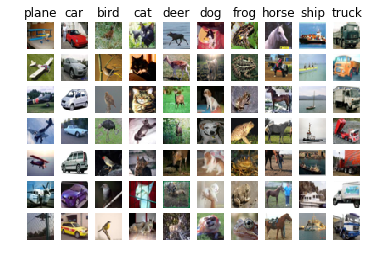

Training data shape:  (49000L, 3072L)
Validation data shape:  (1000L, 3072L)
Test data shape:  (10000L, 3072L)
Training data shape with bias term:  (49000L, 3073L)
Validation data shape with bias term:  (1000L, 3073L)
Test data shape with bias term:  (10000L, 3073L)

Classes:  
plane    car    bird    cat    deer    dog    frog    horse    ship    truck    
OVA Classifier Accuracy:  
0.465    0.463    0.193    0.161    0.234    0.272    0.457    0.406    0.546    0.42    
Softmax Regression Classifier Accuracy:  
0.465    0.486    0.242    0.266    0.299    0.347    0.502    0.425    0.621    0.459    


In [37]:
'''
Problem 7.9. Comparing OVA binary logistic regression with softmax regression
(5 points)
'''

import random
import numpy as np
import matplotlib.pyplot as plt
import utils
from sklearn.multiclass import OneVsRestClassifier
from sklearn import linear_model
from sklearn.metrics import confusion_matrix
# Get the CIFAR-10 data broken up into train, validation and test sets

X_train, y_train, X_val, y_val, X_test, y_test = utils.get_CIFAR10_data()

# Result from OVA classifier
# train on train set with reg
reg = 1.0
sklearn_ova = OneVsRestClassifier(linear_model.LogisticRegression(C=1.0/reg,penalty='l2',
                                                                  fit_intercept=False,solver='lbfgs'))
sklearn_ova.fit(X_train, y_train)     

# predict on test set
y_test_pred_sk = sklearn_ova.predict(X_test)

sk_test_accuracy = np.mean(y_test == y_test_pred_sk)
# print 'one_vs_all on raw pixels final test set accuracy (sklearn): %f' % (sk_test_accuracy, )
ova_confusion_matrix = confusion_matrix(y_test,y_test_pred_sk)  
ova_diag = np.diag(ova_confusion_matrix)
each_category = np.sum(ova_confusion_matrix, axis=1)
ova_accuracies = 1.0 * ova_diag / each_category

# Result from Softmax classifier

softmax_model = linear_classifier.Softmax()
softmax_model.train(X_train, y_train, best_lr, best_reg , best_iteration, best_batch_size)
y_test_pred = softmax_model.predict(X_test)
softmax_confusion_matrix = confusion_matrix(y_test,y_test_pred)
softmax_diag = np.diag(softmax_confusion_matrix)
each_category = np.sum(softmax_confusion_matrix, axis=1)
softmax_accuracies = 1.0 * softmax_diag / each_category

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
print ""
print "Classes:  "
for item in classes:
    print item, "  ",
print ""

print "OVA Classifier Accuracy:  "
for item in ova_accuracies:
    print item, "  ",
print ""

print "Softmax Regression Classifier Accuracy:  "
for item in softmax_accuracies:
    print item, "  ",
print ""